<font size=6>Predicting neurodegenerative status using resting state EEG</font>

<font size=5>Jason Dude</font>

## Overview

For this project I analyzed electroencephalography (EEG) resting state-closed eyes recordings from subjects with Alzheimer's Disease (N=36), Frontotemporal Dementia (N=23), and healthy controls (N=29), with the goal of predicting which group the subject belongs to using spectral features extracted from the EEG recordings. 

These data are publicly available on Kaggle (https://www.kaggle.com/datasets/yosftag/open-nuro-dataset/data), and the corresponding publication can be found at https://doi.org/10.3390/data8060095.

## Abstract

*Introduction*: Alzheimer's Disease (AD) and Frontotemporal Dementia (FTD) are two devastating neurodegenerative diseases with high economic burden[1]. Although AD and FTD often result in similar clinical manifestations, their etiologies are distinct[2], and likely require different clinical interventions. Models that can differentiate between AD, FTD, and cognitively normal subjects (CN) with high accuracy would allow for early intervention and appropriate treatment of these neurodegenerative diseases. 

*Methods*: Participants were diagnosed with AD (N=36), FTD (N=23), or were in the CN group (N=29). Cognitive and neuropsychological state was evaluated by the International Mini-Mental State Examination (MMSE). Resting state eyes-closed electroencephalography (EEG) recordings were obtained, with 19 scalp electrodes placed according to the 10-20 international system. Data were pre-processed using bandpass filtering (0.5-45Hz), artifact subspace reconstruction routine, independent component analysis with automated component rejection, and were then resampled to 128Hz. Bandpower of canonical frequency bands from the 0.5-40Hz range was extracted using Welch's method for channels F3, F4, C3, C4, T3, T4 using all but the first and last minute of the recording. After partitioning the data into train and test sets using stratified random sampling, a support vector machine model (SVM) was trained on 80% of the data using 10-fold cross-validation and a hyperparameter grid search, and then evaluated on the remaining 20% (test set). 

*Results*: As expected, groups differed by MMSE (p < .001 for all comparisons; AD: 17.75, FTD: 22.17, CN: 30). There were no age differences between groups (p=0.11; AD: 66.4, FTD: 63.6, CN: 67.9). The SVM model achieved 95% accuracy on 3-class classification when on the train set (N=70) when using the best hyperparameters, however accuracy dropped to 50% when using the test set for evaluation (N=18). 

*Discussion*: The SVM model performed well during training but not during testing. This discrepancy betweeen training and testing performance can often be explained by the bias-variance tradeoff[3], where the model was likely overfitting on the training data, and the model weights did not generalize well to the new data. Another potential contributor to this discrepancy could be the small test set size (and also small train set), which can cause variability in model performance. Nevertheless, machine learning algorithms show promise for differentiating AD, FTD and cognitive normal subjects, as only a small and simple feature set was used to obtain greater-than-chance accuracy.

## My professional work

I work as a bioinformaticist at WashU in a lab investigating sleep and neurodegeneration. Much of my current work involves extracting features from EEG data, in hopes of developing biomakers that can identify Alzheimer's Disease during the earliest stages; it's easy to see why this dataset was interesting to me!

# Code

## Imports

In [1]:
import os
import re
import mne
import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
from pathlib import Path
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold

## View Demographics/Neurocognitive Status

First we'll open the `participants.tsv` to get an idea of subject demographics, cognitive function and assess class imbalances

In [2]:
df_subjs = pd.read_table('./data/participants.tsv')

In [3]:
df_subjs.head()

,participant_id,Gender,Age,Group,MMSE
0,sub-001,F,57,A,16
1,sub-002,F,78,A,22
2,sub-003,M,70,A,14
3,sub-004,F,67,A,20
4,sub-005,M,70,A,22


In [4]:
df_subjs.dtypes

participant_id    object
Gender            object
Age                int64
Group             object
MMSE               int64
dtype: object

In [5]:
# explicitly make these categorical 
df_subjs[['participant_id', 'Gender', 'Group']] = df_subjs[['participant_id', 'Gender', 'Group']].astype('category')

In [6]:
df_subjs.describe(include='all')

,participant_id,Gender,Age,Group,MMSE
count,88,88,88.000000,88,88.000000
unique,88,2,NaN,3,NaN
top,sub-001,F,NaN,A,NaN
freq,1,44,NaN,36,NaN
mean,NaN,NaN,66.170455,NaN,22.943182
std,NaN,NaN,7.362879,NaN,6.150148
min,NaN,NaN,44.000000,NaN,4.000000
25%,NaN,NaN,61.750000,NaN,20.000000
50%,NaN,NaN,67.000000,NaN,22.000000
75%,NaN,NaN,71.000000,NaN,30.000000


In [7]:
df_subjs.groupby(['Gender', 'Group']).count()

participant_id  Age  MMSE
Gender Group                           
F      A                  24   24    24
       C                  11   11    11
       F                   9    9     9
M      A                  12   12    12
       C                  18   18    18
       F                  14   14    14

In [8]:
df_subjs['Group'] = df_subjs['Group'].map({'A': 'AD', 'C': 'CN', 'F': 'FTD'})

### Group comparisons

Let's quantify group averages for age and MMSE.

In [9]:
df_subjs.groupby('Group')[['Age', 'MMSE']].agg('mean')

,Age,MMSE
Group,,
AD,66.388889,17.750000
CN,67.896552,30.000000
FTD,63.652174,22.173913


In [10]:
pg.anova(df_subjs, dv='Age', between='Group')

,Source,ddof1,ddof2,F,p-unc,np2
0,Group,2,85,2.218462,0.115037,0.04961


In [11]:
pg.anova(df_subjs, dv='MMSE', between='Group')

,Source,ddof1,ddof2,F,p-unc,np2
0,Group,2,85,119.735045,1.885302e-25,0.738034


The ANOVA is significant for MMSE, so we need to follow up with post-hoc tests to compare groups.

In [12]:
pg.ttest(df_subjs[df_subjs['Group'] == 'AD']['MMSE'], df_subjs[df_subjs['Group'] == 'FTD']['MMSE'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.755321,56.69173,two-sided,0.000014,"[-6.29, -2.56]",1.137566,1243.678,0.987085


In [13]:
pg.ttest(df_subjs[df_subjs['Group'] == 'AD']['MMSE'], df_subjs[df_subjs['Group'] == 'CN']['MMSE'])

/Users/jasondude/Library/Python/3.11/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-16.333333,35.0,two-sided,6.007719e-18,"[-13.77, -10.73]",3.652244,8.522e+20,1.0


In [14]:
pg.ttest(df_subjs[df_subjs['Group'] == 'FTD']['MMSE'], df_subjs[df_subjs['Group'] == 'CN']['MMSE'])

/Users/jasondude/Library/Python/3.11/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-14.218137,22.0,two-sided,1.435111e-12,"[-8.97, -6.68]",4.469433,8.305e+15,1.0


Let's also plot these data so we get an idea of the distributions.

<Axes: xlabel='Age', ylabel='Count'>

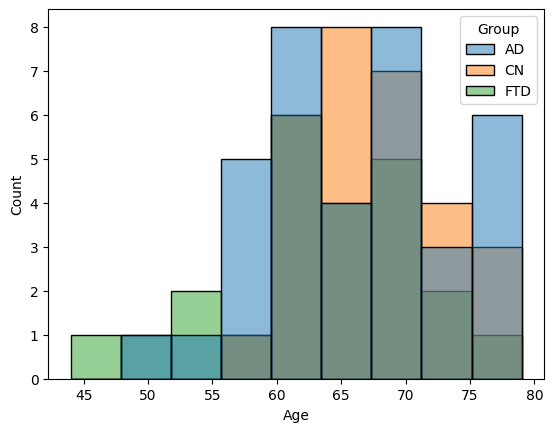

In [15]:
sns.histplot(df_subjs, x='Age', hue='Group')

<Axes: xlabel='MMSE', ylabel='Count'>

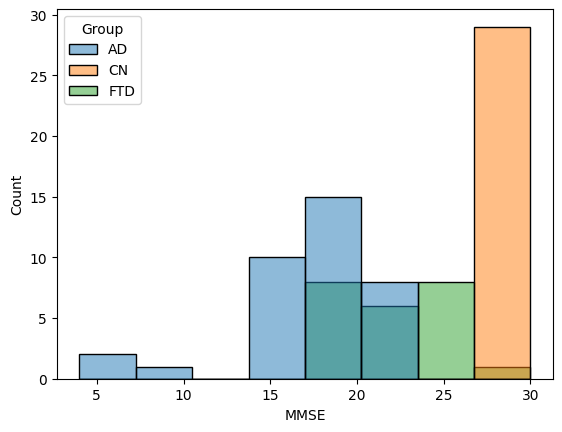

In [16]:
sns.histplot(df_subjs, x='MMSE', hue='Group')

## Read EEG and compute spectral features

In the code chunk below I read in EEG data, resample to 128hz and compute the power spectral density (excluding first and last minute, which are likely to be noiser segments).

In [17]:
%%capture

path_set = Path('./data/derivatives')
set_files = sorted(path_set.glob('**/**/*.set'))

if os.path.exists('./data/psds.p'):
    psds, ids = pickle.load(open('./data/psds.p', 'rb' ))
else:
    ids = []
    psds = []
    for f in set_files:

        idx = re.search('sub-[0-9]{3}', str(f))[0]
        ids.append(idx)

        raw = mne.io.read_raw_eeglab(f, preload=True)
        raw.resample(128)

        psd = raw.compute_psd(fmin=0.5, fmax=40, tmin=60, tmax=(raw.n_times / raw.info['sfreq']) - 60)
        psds.append(psd)
        pickle.dump((psds, ids), open('./data/psds.p', 'wb' ))

Now we'll concatenate all of the power spectrums into one data frame.

In [18]:
df_psds = []
for i in range(len(ids)):
    df_psd = psds[i].to_data_frame()
    df_psd.insert(0, 'participant_id', ids[i])
    df_psd['participant_id'] = df_psd['participant_id'].astype('category')
    df_psds.append(df_psd)
    
df_psds = pd.concat(df_psds)
df_psd = pd.merge(df_subjs, df_psds)

### Plot power spectrum for quality assurance

Let's plot individual power spectrums for each channel, overlayed with the average, to see what kind of variability/noise exists.

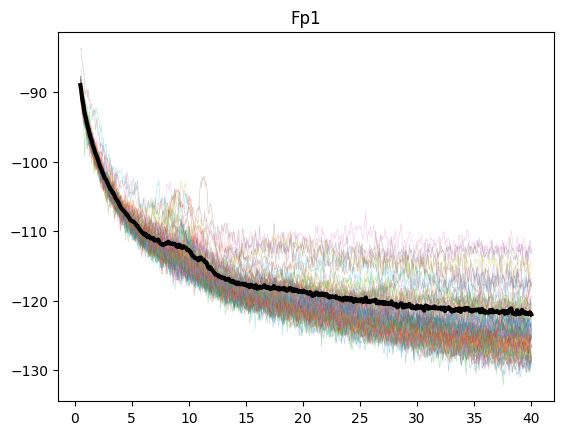

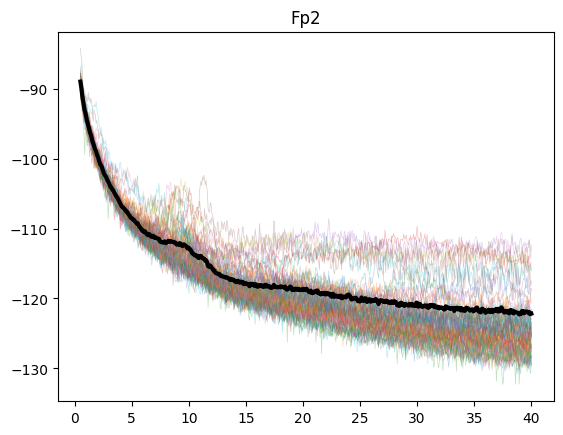

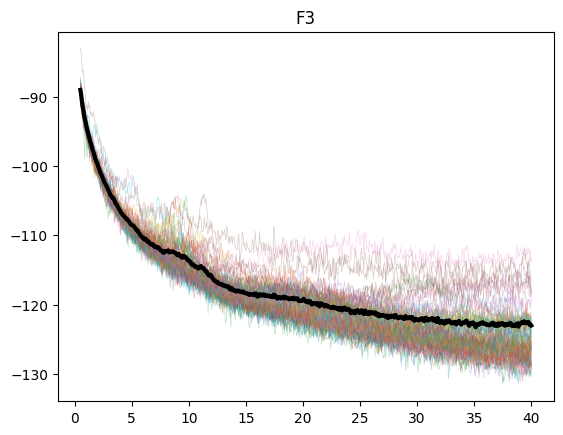

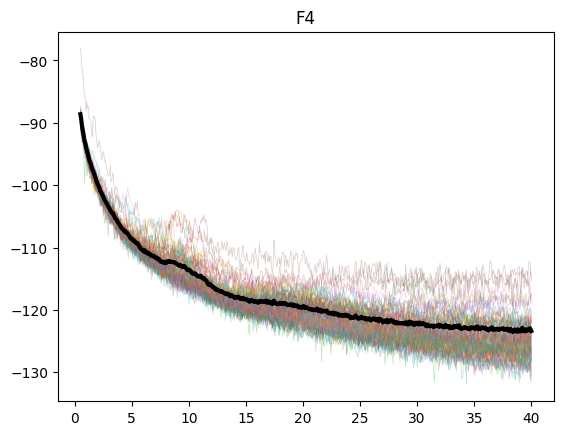

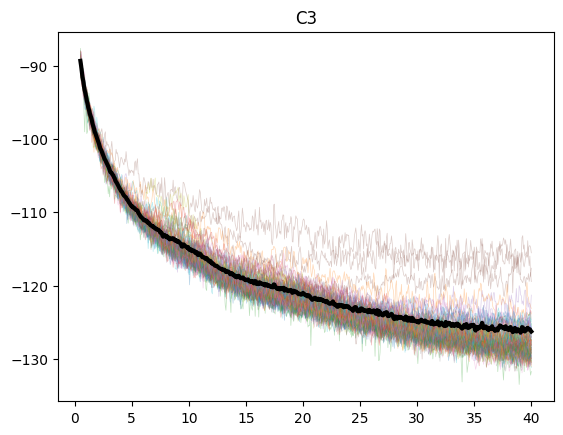

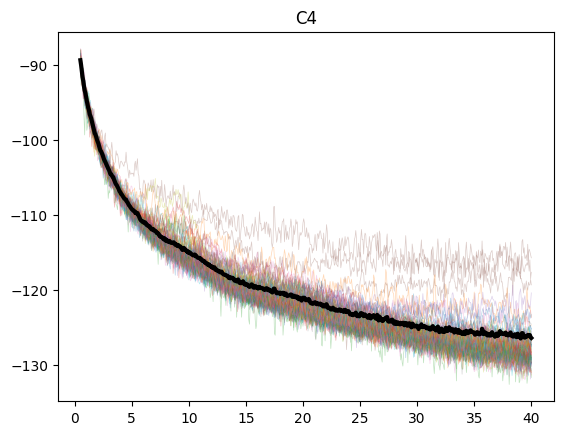

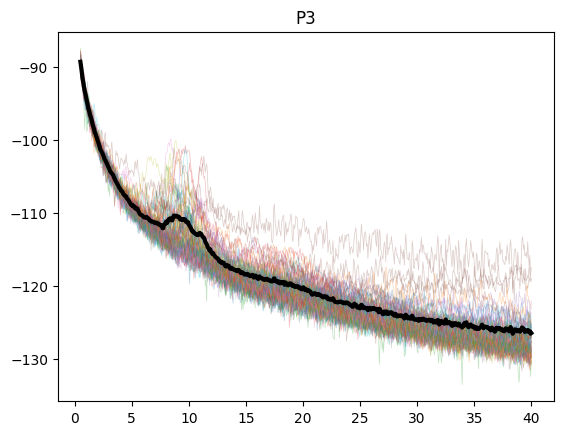

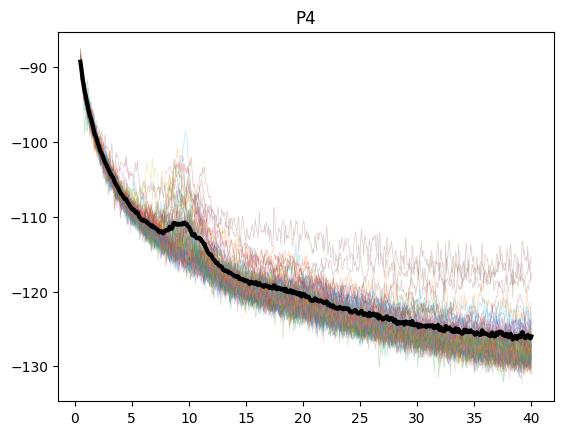

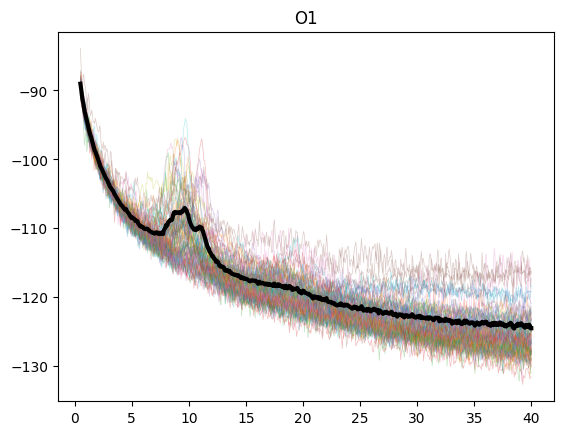

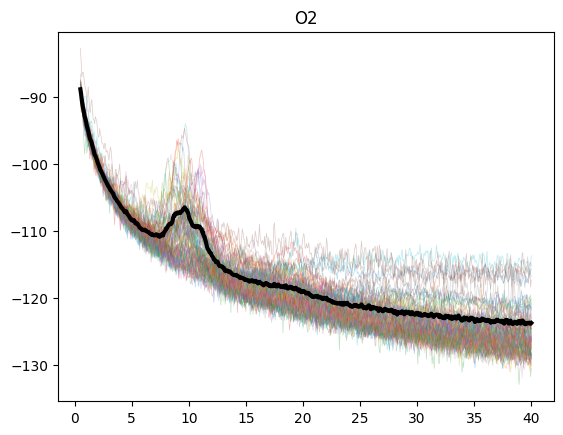

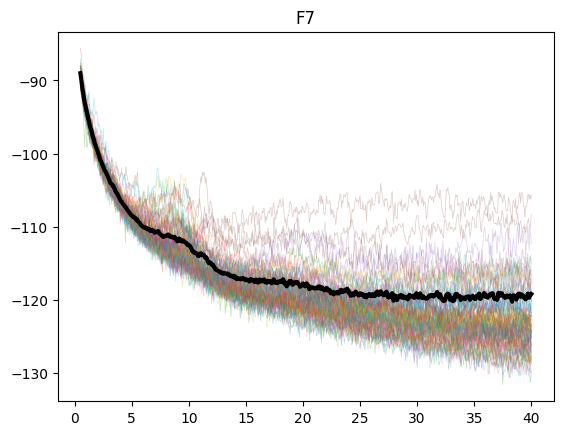

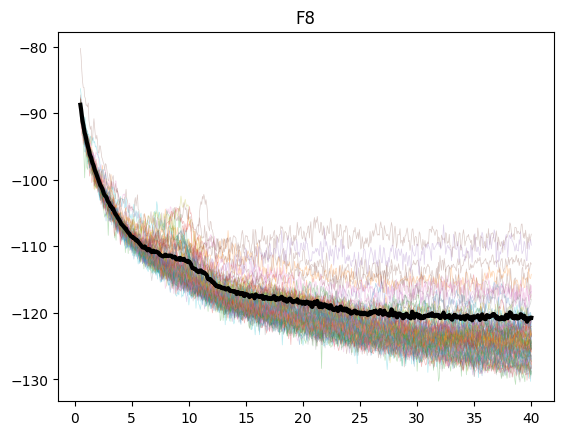

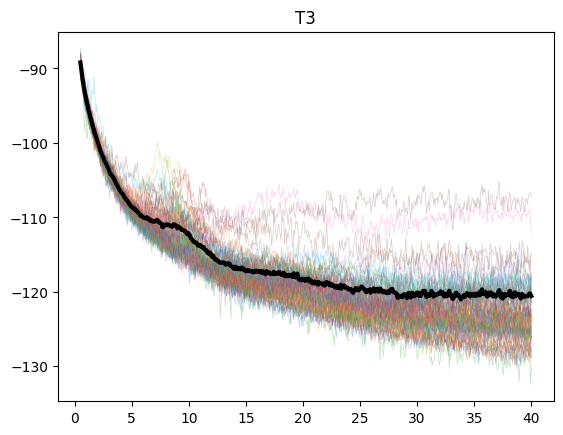

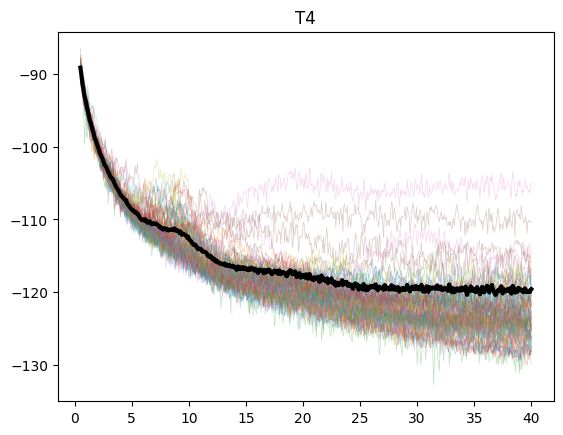

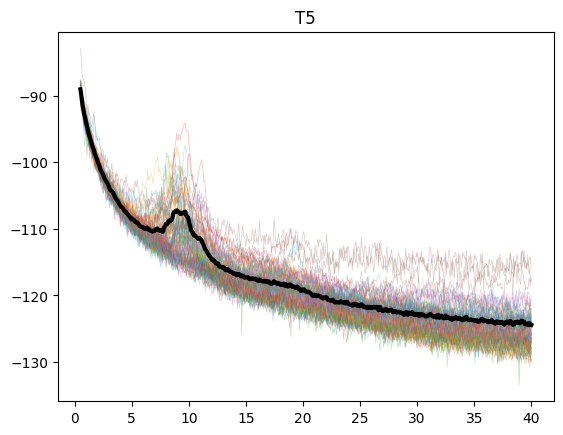

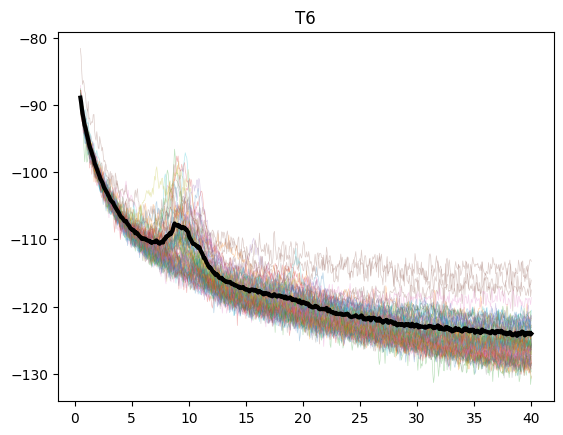

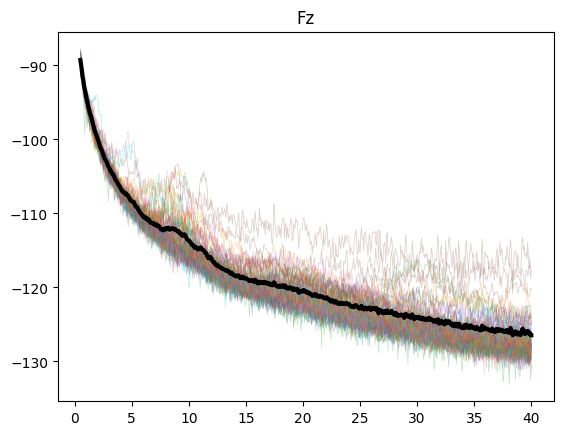

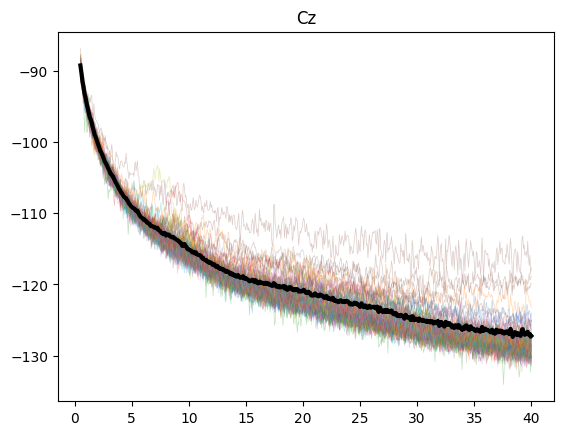

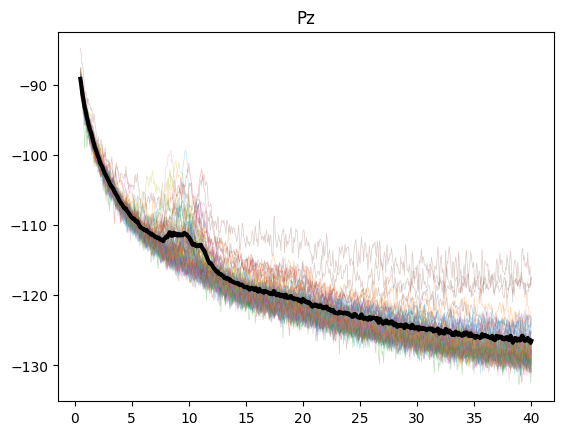

In [19]:
eeg_cols = df_psd.columns[6:]
df_means = df_psd.groupby('freq')[eeg_cols].agg('mean').reset_index()

for chan in eeg_cols:
    plt.figure()
    for idx in np.unique(df_psd['participant_id']):
        tmp = df_psd[df_psd['participant_id'] == idx]    
        plt.plot(tmp['freq'], 10*np.log10(tmp[chan]), linewidth=0.5, alpha=.3)
        plt.title(chan)
    plt.plot(df_means['freq'], 10*np.log10(df_means[chan]), linewidth=3, color='black')
    plt.show()

### Compute Bandpower

To reduce the number of features, we'll compute the bandpower rather than using the spectral content from all obtained frequencies. To do this, we can simply integrate over the selected frequency bands. We'll then convert to decibels to mitigate the effect of extreme outliers.

In [20]:
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 40)
}

To reduce the number of features we'll select only a subset of channels because 1) channels are likely highly correlated anyway and 2) some channels have high alpha power reflecting posterior dominant rhythm activity, which can lead to differences in alpha power that are not reflective of real differences in neurocognitive status. 

In [21]:
include_chans = ['F3', 'F4', 'C3', 'C4', 'T3', 'T4']

In [22]:
# dx will always be the same since the sampling rate is the same
dx = df_psd['freq'][1] - df_psd['freq'][0]

# integrate over frequency bands, convert to decibel, save in data frame
df_bps = []
for idx in np.unique(df_psd['participant_id']):
    tmp = df_psd[df_psd['participant_id'] == idx]
    bp_names = []
    bp_values = []
    df = pd.DataFrame()
    for k,v in bands.items():
        res = tmp[np.logical_and(tmp['freq'] >= v[0], tmp['freq'] < v[1])]
        bp = scipy.integrate.trapezoid(res[include_chans], dx=dx, axis=0)
        bp_names.append([k + '_' + x for x in include_chans])
        bp_values.append(bp)
    df = pd.DataFrame(np.reshape(np.concatenate(bp_values), (1, -1)), columns=np.concatenate(bp_names))
    df = df.apply(lambda x: 10*np.log10(x))
    df.insert(0, 'participant_id', idx)
    df_bps.append(df)
df_bp = pd.concat(df_bps)

Let's see what the resultant data frame looks like.

In [23]:
df_bp = pd.merge(df_subjs[['participant_id', 'Group']], df_bp)
df_bp

,participant_id,Group,delta_F3,delta_F4,delta_C3,delta_C4,delta_T3,delta_T4,theta_F3,theta_F4,...,beta_C3,beta_C4,beta_T3,beta_T4,gamma_F3,gamma_F4,gamma_C3,gamma_C4,gamma_T3,gamma_T4
0,sub-001,AD,-91.709959,-91.671558,-91.786505,-91.744036,-91.738997,-91.730676,-104.132619,-104.070313,...,-110.103569,-110.104541,-109.372763,-109.265245,-116.374801,-115.242688,-117.794997,-117.655710,-115.914054,-115.038730
1,sub-002,AD,-92.311329,-92.366023,-92.314162,-92.359030,-92.248231,-92.315208,-104.591471,-104.528391,...,-109.934857,-109.907008,-107.575512,-107.920284,-115.008815,-113.973669,-118.170892,-118.188076,-114.497863,-114.540544
2,sub-003,AD,-93.417349,-93.406196,-93.605353,-93.582888,-93.476671,-93.511598,-103.572801,-103.510641,...,-110.266058,-110.379101,-109.730308,-109.749045,-117.501210,-118.035344,-118.757454,-118.909768,-118.119318,-117.719525
3,sub-004,AD,-92.160893,-92.120565,-92.263257,-92.255794,-92.060604,-92.137031,-104.038011,-104.010445,...,-110.072617,-110.165058,-108.701841,-107.336944,-107.447674,-112.509641,-116.368542,-116.699007,-113.399300,-111.412203
4,sub-005,AD,-91.972161,-92.007062,-92.258315,-92.247429,-92.075069,-92.142594,-104.333214,-104.427792,...,-109.748692,-109.736924,-106.463059,-107.900107,-113.568387,-113.746785,-116.738825,-116.993018,-109.657401,-112.862402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,sub-084,FTD,-93.374062,-93.122826,-93.447958,-93.489236,-92.930962,-93.281812,-104.503367,-104.520062,...,-109.382493,-109.404957,-106.943829,-106.502036,-114.633365,-111.907593,-115.823052,-116.131716,-111.144503,-110.118580
84,sub-085,FTD,-91.531852,-91.571980,-91.609593,-91.595229,-91.556051,-91.571138,-102.716267,-103.099850,...,-108.452174,-108.309663,-106.909411,-105.793664,-107.586061,-109.334142,-112.426249,-112.125193,-109.753154,-108.637634
85,sub-086,FTD,-87.055768,-83.393225,-92.093468,-91.899705,-90.696771,-90.020004,-102.549674,-101.308701,...,-103.624080,-103.761460,-96.423830,-96.938425,-104.690308,-104.624603,-105.902826,-106.157706,-97.727295,-99.877735
86,sub-087,FTD,-91.962476,-91.957410,-92.046165,-92.073812,-91.748626,-91.887071,-104.204647,-104.493456,...,-109.797446,-110.002651,-108.375163,-108.020760,-117.867892,-117.943221,-118.987403,-119.043595,-114.924830,-114.494845


## Train/Test Split

Before modeling we need to split into train and test sets.

In [24]:
df_train,df_test = train_test_split(df_bp, train_size=0.8, random_state=123, stratify=df_bp['Group'])

X_train = df_train.iloc[:, ~df_train.columns.isin(['participant_id', 'Group'])]
y_train = df_train['Group']

X_test = df_test.iloc[:, ~df_test.columns.isin(['participant_id', 'Group'])]
y_test = df_test['Group']

## Group Power Spectrum Differences

Now that we've identified the train set, we can visualize group differences in the power spectrum (which should be similar to bandpower differences).

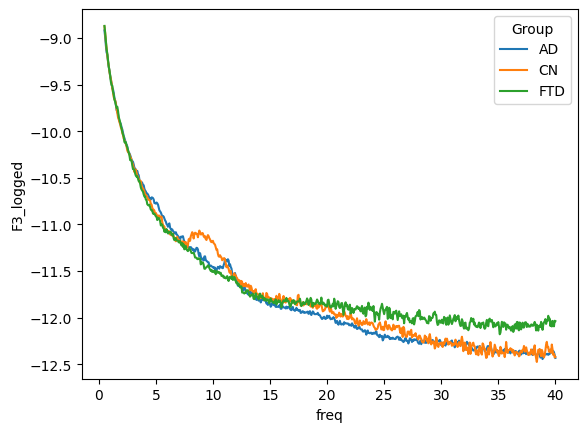

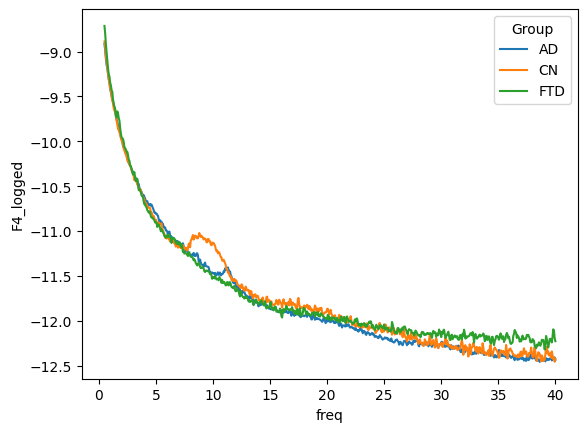

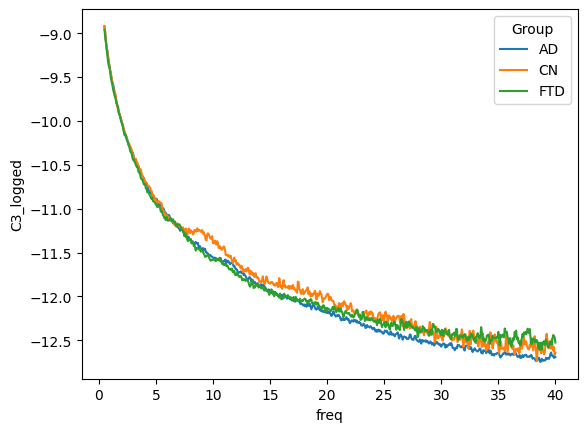

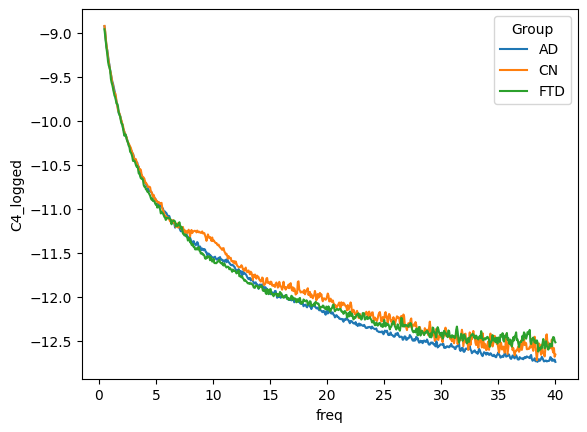

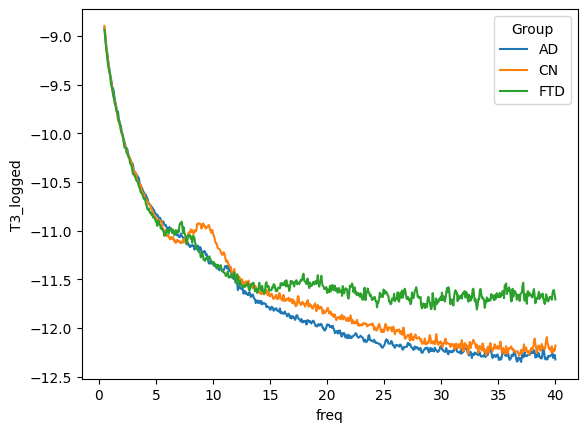

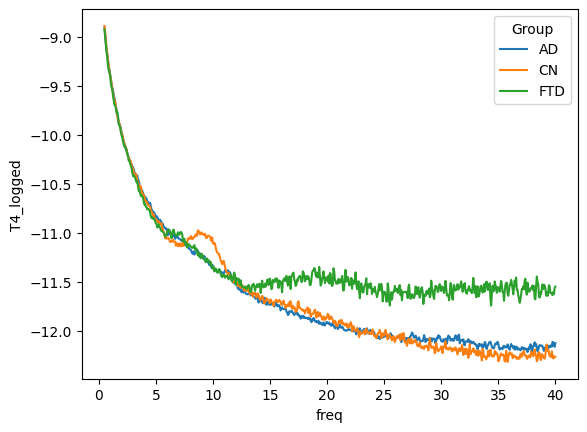

In [25]:
df_psd_train = df_psd[df_psd['participant_id'].isin(df_train['participant_id'])]
df_group_means = df_psd_train.groupby(['Group', 'freq'])[include_chans].agg('mean').reset_index()

for c in include_chans:
    plt.figure()
    df_group_means[c + '_logged'] = np.log10(df_group_means[c])
    sns.lineplot(df_group_means, x='freq', y=c+'_logged', hue='Group')
    plt.show()

## Model

I'll use a support vector machine, which is common in EEG classification problems[4].

In [26]:
# support vector machine model
svm_model = SVC()

# create a pipeline with centering/scaling as preprocessing step
pipeline = make_pipeline(StandardScaler(), svm_model)

# parameter grid to search through
param_grid = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 10],
    'svc__kernel': ['rbf', 'linear']
}

# 10-fold cross-validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=123)

# performing grid search with cross-validation
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=k_fold)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10],
                         'svc__gamma': [0.001, 0.01, 0.1, 1, 10],
                         'svc__kernel': ['rbf', 'linear']})

In [27]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}


## Results

First let's select the best parameters and re-fit on the train set.

In [28]:
# use best parameters and re-fit
model = grid.best_estimator_
y_pred = model.predict(X_train)

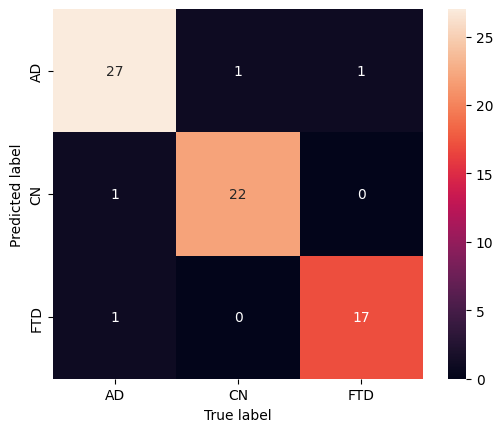

In [29]:
mat = confusion_matrix(y_train, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, 
            xticklabels=grid.classes_,
            yticklabels=grid.classes_)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [30]:
accuracy_score(y_train, y_pred)

0.9428571428571428

Wow, performance is great! Will that carry over to the test set though?

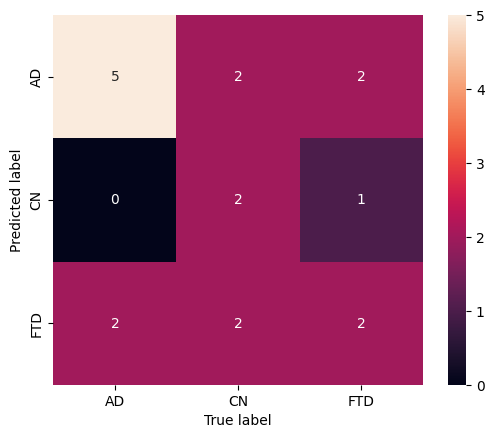

In [31]:
y_pred = model.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, 
            xticklabels=grid.classes_,
            yticklabels=grid.classes_)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [32]:
accuracy_score(y_test, y_pred)

0.5

Unfortunately we do not see the same performance on the test set :( This is likely due to overfitting on the train set. However, it's still better than chance, and it took very little time (both programming-wise and computation-wise) to achieve better-than-chance results, so that's good! As a next step I would put more time into data visualization (always important) and try several other ML algorithms that are good for reducing overfitting, such as logistic regression with regularization.

## References

1. Meek, P. D., McKeithan, E. K., & Schumock, G. T. (1998). Economic considerations in Alzheimer's disease. Pharmacotherapy: The Journal of Human Pharmacology and Drug Therapy, 18(2P2), 68-73.
2. Wider, C., & Wszolek, Z. K. (2008). Etiology and pathophysiology of frontotemporal dementia, Parkinson disease and Alzheimer disease: lessons from genetic studies. Neurodegenerative Diseases, 5(3-4), 122-125.
3. Briscoe, E., & Feldman, J. (2011). Conceptual complexity and the bias/variance tradeoff. Cognition, 118(1), 2-16.
4. Guler, I., & Ubeyli, E. D. (2007). Multiclass support vector machines for EEG-signals classification. IEEE transactions on information technology in biomedicine, 11(2), 117-126.
